<font color='blue'>
    
# Here, we start to import code from "Mean_Field Dynamics Spectrum_by_VB.ipynb"

</font>

In [1]:
## Imports
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import scipy.constants as const
from scipy.integrate import odeint
from matplotlib import rc
from scipy.optimize import fsolve
from math import exp
import h5py
from mpl_toolkits import mplot3d
%matplotlib inline

## Functions:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

#Mean field steady-state equations for the effective master equation
def MFEquationsEffective(vars, *data):
    
    bR, bI, smR, smI, sz = vars
    bb = bR + 1j*bI
    smi = smR + 1j*smI
    
    eps_q, eps_r, dr, dq, dqb, chi, gb, gamma_b, kappa, gamma_1, gamma_phi = data
    #The phonon is always driven in resonance
    db = 0.
    gamma_2 = gamma_phi + gamma_1/2
    algs = 1j*eps_r/(1j*(dr + chi) - kappa/2)
    ales = 1j*eps_r/(1j*(dr - chi) - kappa/2)
    
    Bss = 2*chi*np.real(algs*np.conj(ales))
    Gss = 2*chi*np.imag(algs*np.conj(ales))
    
    eqb = (1j*db - gamma_b/2)*bb - 1j*gb*smi
    eqsmi = (1j*(dq - Bss) - (gamma_2+Gss) )*smi + 1j*gb*bb*sz +1j*eps_q*sz
    eqsz = -4*gb*np.imag(np.conj(bb)*smi)-4*eps_q*np.imag(smi)-gamma_1*(sz+1)
    
    return [np.real(eqb),np.imag(eqb), np.real(eqsmi),np.imag(eqsmi), eqsz]

#Mean field equations for the effective master equation, this function will be used to compute
#the dynamics of the system
def MFEquationsDynamics(z, t, eps_q, eps_r, dr, dq, dqb, chi, gb, gamma_b, kappa, gamma_1, gamma_phi):
    
    bR = z[0]
    bI = z[1]
    smR = z[2]
    smI = z[3]
    sz = z[4]
    
    bb = bR + 1j*bI
    smi = smR + 1j*smI
    
    
    #The phonon is always driven in resonance with the qubit drive!
    db = 0.
    gamma_2 = gamma_phi + gamma_1/2
    
    algs = 1j*eps_r/(1j*(dr + chi) - kappa/2)
    
    xie = 1j*(dr - chi) - kappa/2
    exie = np.exp(xie*t)
    ale = algs*exie +(1-exie)*1j*eps_r/xie

    
    Bss = 2*chi*np.real(algs*np.conj(ale))
    Gss = 2*chi*np.imag(algs*np.conj(ale))
    
    eqb = (1j*db - gamma_b/2)*bb - 1j*gb*smi
    eqsmi = (1j*(dq - Bss) - (gamma_2+Gss) )*smi + 1j*gb*bb*sz +1j*eps_q*sz
    eqsz = -4*gb*np.imag(np.conj(bb)*smi)-4*eps_q*np.imag(smi)-gamma_1*(sz+1)
    
    return [np.real(eqb),np.imag(eqb), np.real(eqsmi),np.imag(eqsmi), eqsz]

In [2]:
#Parameters - here everything is in GHz.

#Qubit decay and dephasing
g2 = 0.425/10**(3)
gamma_1 = 2*g2
gamma_phi = g2/10

#cavity decay
kappa = 2.897/10**(3)

#phonon-qubit coupling
gb=  0.162/10**(3)

#phonon-qubit cooperativity
Co = 7.7/10**3

#phonon decay
gamma_b = 4*gb**2/(2*Co)

#dispersive cavity-qubit coupling
chi = -1.22/(10**3)

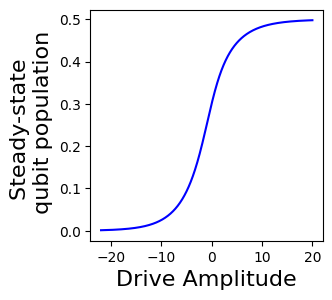

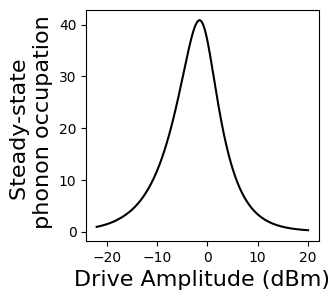

In [3]:
corr = 7.5
power0 = np.linspace(-22., 20., 1000)
# power0 = [-22.]


szER = []
nbER= []
sxER = []
syER = []
nbS = []


#This is an initial guess that you have to give for the solver
s0E = [0., 0., 0., 0., -1]

dets = []

for poww in power0:
    powwdb = poww+corr
    eq = np.sqrt(10**(powwdb / 10.0))/10**(3)
    P = poww
    ng = 0.00232968*P**2 + 0.12955201*P + 2.46594372
    er = np.sqrt(ng/(0.476))/10**3
#    dqb = wq - wb
    if poww < -18:
        dqb = 3.325/10**3
    else:
        dqb = (5.584 +0.1335*P)/10**3
    #Detuning scheme
    dr = -chi
    #Qubit-drive detuning detuning wd - wq = wb - wq = - dqb
    dq = -dqb
    #when we know the difference between qubit and phonon mode from data (see above cells) uncommand the below!
#     dq = ((f_qubitData - f_ph)/1e6)/10**3
    
    data = (eq, er, dr, dq, dqb, chi, gb, gamma_b, kappa, gamma_1, gamma_phi)
    solE = fsolve(MFEquationsEffective, s0E, args=data)
    s0E = solE
    szER.append(solE[-1])
    sxER.append(2*solE[2])
    syER.append(-2*solE[3])
    nbER.append(solE[0]**2 + solE[1]**2)
    
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(power0, (1+np.array(szER))/2,  'b')
ax.set_xlabel('Drive Amplitude',fontsize = 16)
ax.set_ylabel('Steady-state \n qubit population',fontsize = 16)
plt.show()

#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(power0, np.array(nbER),  'k')
ax.set_xlabel('Drive Amplitude (dBm)',fontsize = 16)
ax.set_ylabel('Steady-state \n phonon occupation',fontsize = 16)
plt.show()

# Then we combine them together as one figure for the paper!

# Load generated Master equation data from Clinton:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

ME_data = np.load('New_Phonon_Num_Data.npy',allow_pickle=True)

b_num = ME_data.item()['b_num']
D_pows = ME_data.item()['D_pows']

# plt.plot(D_pows,b_num,'.')

## Settings for figure:

In [5]:
### IMPORTS ###
import glob, os, datacube, xarray, bokeh, time, math, scipy
import stlabutils;   # import stlab
import numpy as np

import matplotlib.pyplot  as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.pyplot import cm
import matplotlib.image as mpimg

### RC params ####
# plt.rc('font', size=8)          # controls default text sizes
# plt.rc('axes', labelsize=8)    # axis labels
# plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
# plt.rc('legend', fontsize=6)    # legend fontsize
### RC params ####
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', labelsize=14)    # axis labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

# rc params linecuts
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linestyle'] = ':'
plt.rcParams['lines.markersize'] = 1

# rc params colorplots:


# rc params general plotting:
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (8,10)
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.format'] = 'pdf'#'png'#'jpg'

/opt/lib/stlabutils/stlabdict.py:908: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if func is '':


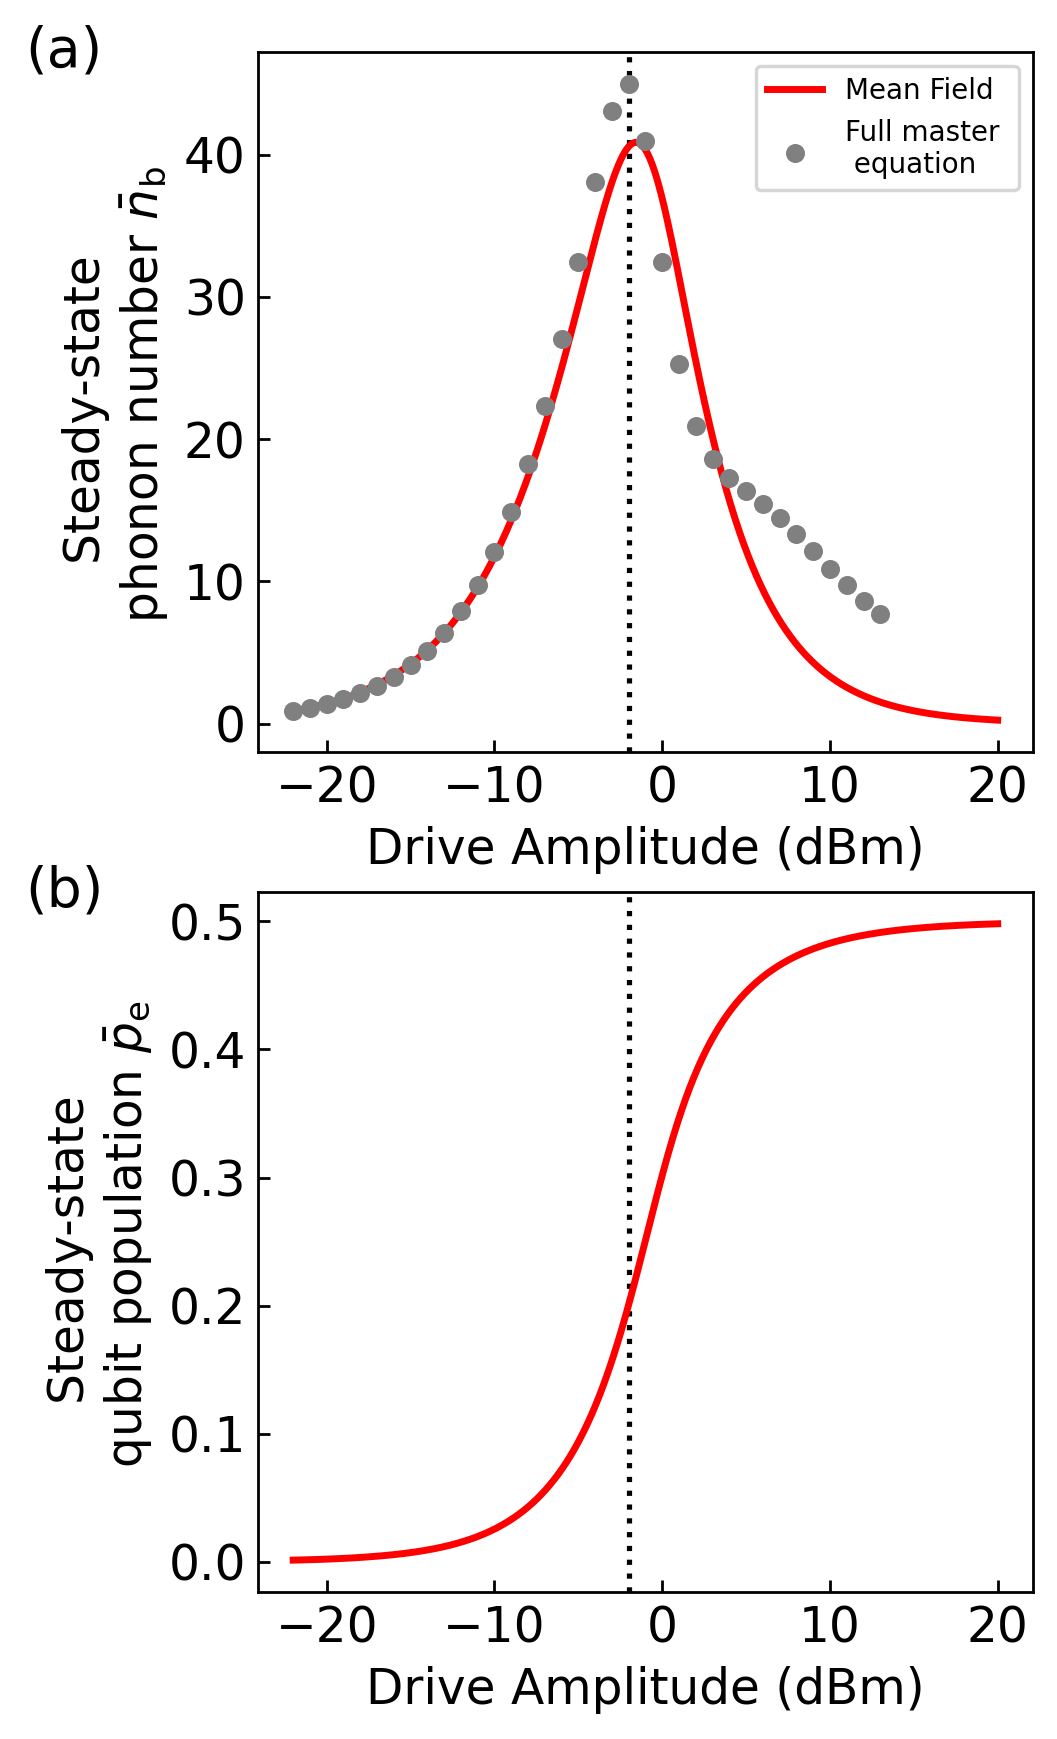

In [6]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(4,8))

### Panel A ###
#MF data
ax1.axvline(x = D_pows[np.argmax(b_num)],color='k',lw=1.5)
ax1.plot(power0, np.array(nbER),  'r-',linewidth=2, label='Mean Field')
ax1.set_xlabel('Drive Amplitude (dBm)')
ax1.set_ylabel('Steady-state \n phonon number '+ r'$\bar{n}_{\rm b}$')
#ME data
ax1.scatter(D_pows,b_num, s=20, c='grey', marker='o',label = 'Full master \n equation',zorder=2)
ax1.legend(prop = { "size": 8 }, loc ="upper right")

### Panel B ###
ax2.axvline(x = D_pows[np.argmax(b_num)],color='k',lw=1.5)
ax2.plot(power0, (1+np.array(szER))/2, 'r-',linewidth=2)
ax2.set_xlabel('Drive Amplitude (dBm)')
ax2.set_ylabel('Steady-state \n qubit population '+ r'$\bar{p}_{\rm e}$')

#figurelabel    
ax1.text(-0.25, 1, r'(a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax1.transAxes, color='k')
ax2.text(-0.25, 1, r'(b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax2.transAxes, color='k')

## Save data:
# plt.savefig('AIT_SI_FIG_meanfield_newNumbers',bbox_inches = 'tight')

plt.show()

In [7]:
# print(np.max(b_num))
# print(np.argmax(b_num))
# print(b_num[np.argmax(b_num)])

# print(D_pows[np.argmax(b_num)])

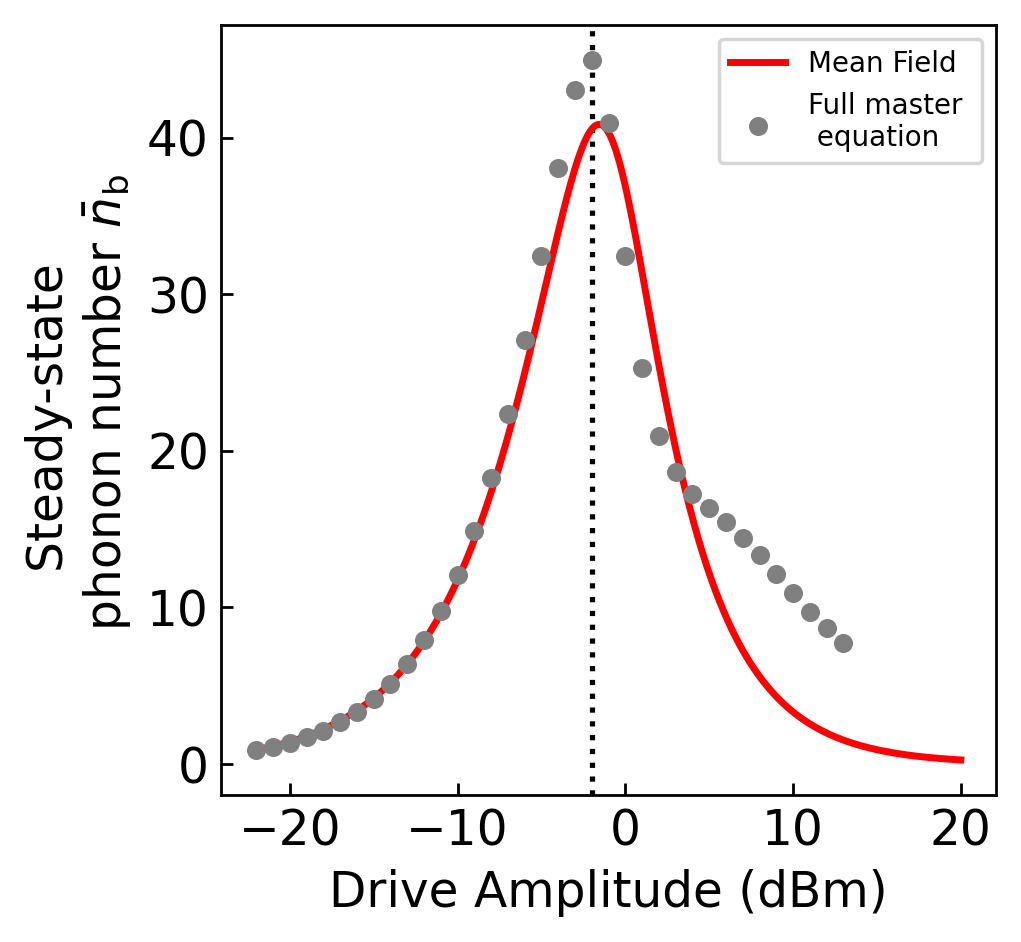

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize=(4,4))

### Panel A ###
#MF data
ax1.axvline(x = D_pows[np.argmax(b_num)],color='k',lw=1.5)
ax1.plot(power0, np.array(nbER),  'r-',linewidth=2, label='Mean Field')
ax1.set_xlabel('Drive Amplitude (dBm)')
ax1.set_ylabel('Steady-state \n phonon number '+ r'$\bar{n}_{\rm b}$')
#ME data
ax1.scatter(D_pows,b_num, s=20, c='grey', marker='o',label = 'Full master \n equation',zorder=2)
ax1.legend(prop = { "size": 8 }, loc ="upper right")


## Save data:
# plt.savefig('AIT_SinglePlot_maintext_meanfield_newNumbers',bbox_inches = 'tight')

plt.show()